In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.stats import skew, kurtosis, pearsonr
from scipy.signal import butter, welch, filtfilt, resample
import math
import nolds
import pywt
from PreprocessFcns import *
%matplotlib inline

In [2]:
full_dict = {}
count = 0
subj_list = ([1004,1016,1018,1019,1020,1024,1029,1030,1032,1038,1044,1046,1047,1049,1051,1052,1053,1054,1055,1056])
for subj in subj_list:
    f = open('Z:\CIS-PD Study\Data_dict\\' + str(subj) + 'dict.pkl', 'rb')
    full_dict[subj] = (pickle.load(f))
    f.close()
    count = count + 1
    if count < 10:
        print(' ' + str(count) + ' of 20 subjects loaded')
    else:
        print(str(count) + ' of 20 subjects loaded')

 1 of 20 subjects loaded
 2 of 20 subjects loaded
 3 of 20 subjects loaded
 4 of 20 subjects loaded
 5 of 20 subjects loaded
 6 of 20 subjects loaded
 7 of 20 subjects loaded
 8 of 20 subjects loaded
 9 of 20 subjects loaded
10 of 20 subjects loaded
11 of 20 subjects loaded
12 of 20 subjects loaded
13 of 20 subjects loaded
14 of 20 subjects loaded
15 of 20 subjects loaded
16 of 20 subjects loaded
17 of 20 subjects loaded
18 of 20 subjects loaded
19 of 20 subjects loaded
20 of 20 subjects loaded


In [3]:
MDS_scores = pd.read_excel('Z:CIS-PD Study\Scores\MDS-UPDRS Scores.xlsx', header=4)
MDS_scores['Trial'] = pd.Series(np.ones(40),dtype='int32')
for i in range(40):
    if MDS_scores.iat[i,2] == '2 Weeks: Time 0':
        MDS_scores.loc[i,'Trial'] = 0
MDS_scores = MDS_scores.iloc[:,[1,46,16,17,18,19,20,21,22,23,24,25,26,27,29,32,33,34,35]]
MDS_scores

,Subject,Trial,3.4 Finger Tapping - Right Hand (Q40),3.4 Finger Tapping - Left Hand (Q41),3.5 Hand Movements - Right Hand (Q42),3.5 Hand Movements - Left Hand (Q43),3.6 Pronation-Supination Movements of Hands - Right Hand (Q44),3.6 Pronation-Supination Movements of Hands - Left Hand (Q45),3.7 Toe Tapping - Right Foot (Q46),3.7 Toe Tapping - Left Foot (Q47),3.8 Leg Agility - Right Leg (Q48),3.8 Leg Agility - Left Leg (Q49),3.9 Arising From Chair (Q50),3.10 Gait (Q51),3.12 Postural Stability (Q53),3.15 Postural Tremor of the Hands - Right Hand (Q56),3.15 Postural Tremor of the Hands - Left Hand (Q57),3.16 Kinetic Tremor of the Hands - Right Hand (Q58),3.16 Kinetic Tremor of the Hands - Left Hand (Q59)
0,1004,0,1,2,1,2,1,2,2,3,1,2,0,1,0,1,1,1,1
1,1004,1,1,1,1,1,0,0,1,2,0,1,0,0,0,0,0,0,0
2,1016,0,1,1,1,1,1,1,1,1,1,1,2,1,0,0,0,1,0
3,1016,1,1,1,0,0,2,1,1,1,1,1,2,1,2,0,0,1,1
4,1018,0,1,2,0,1,0,1,0,2,0,2,0,0,0,0,0,0,0
5,1018,1,0,1,0,1,0,1,0,2,0,1,0,0,0,0,0,0,1
6,1020,0,2,2,1,0,1,0,2,1,1,1,0,0,0,1,0,0,0
7,1020,1,2,1,1,1,1,0,2,1,1,1,0,0,0,0,0,0,0
8,1024,0,1,1,1,1,1,2,1,2,1,2,3,3,0,1,2,1,2
9,1024,1,1,1,1,1,0,1,0,2,0,1,1,1,0,0,1,0,1


In [41]:
def DataAggregator_MDS(full_dict,subj_list,MDS_task_list,task_list,loc_list):
    clipsize = 5000
    overlap = 0
    sensor='elec'
    
    Data = pd.DataFrame()
    Unprocessed_Data = pd.DataFrame()
    
    for subj_index in range(20):
        
        row = 0
        subj = subj_list[subj_index]
        act_dict = full_dict[subj]

        print('Subject ' + str(subj) + ' (' + str(subj_index + 1) + ' of 20)')

        for task_index in range(10):

            task = MDS_task_list[task_index]

            #No second trial for some subjects
            if len(list(act_dict[task].keys())) < 2:
                r = len(list(act_dict[task].keys()))
            else:
                r = 2

            for trial in range(r):

                row = trial + 2*subj_index

                for loc_index in range(2):
                    
                    loc = loc_list[loc_index]
                    
                    #Missing data or data length of 6
                    if len(act_dict[task][trial][loc][sensor]) <= 6:
                        #D = pd.DataFrame()
                        if trial == 0:
                            visit = '2 Weeks: Time 0'
                        else:
                            visit = '2 Weeks: Time 60'
                        D['Visit'] = visit
                        D['Task'] = task
                        D['Loc'] = loc
                        D['Subject'] = subj
                        D['Error'] = 'Insufficient Data'
                        Unprocessed_Data = pd.concat([Unprocessed_Data,D])
                        continue

                    #print('Task:' + str(task) + ', Trial:' + str(trial) + ', Loc:' + str(loc))
                    column = task_list[loc_index + 2*task_index]
                    
                    score = MDS_scores.loc[row,column]

                    ZInds = np.diff(act_dict[task][trial][loc][sensor].index)!=0
                    act_dict[task][trial][loc][sensor] = act_dict[task][trial][loc][sensor][np.hstack((ZInds,np.array(True)))]
                    filterdata(act_dict,task,loc,trial,sensor,ftype='bandpass',cutoff_bp=[20,70])
                    
                    #DC Rectify
                    act_dict[task][trial][loc][sensor] = np.absolute(act_dict[task][trial][loc][sensor])
                    
                    clip_data = gen_clips_EMG(act_dict,task,trial,loc)

                    #No data for some subjects
                    if len(clip_data[trial][sensor]['data']) == 0:
                        #D = pd.DataFrame()
                        if trial == 0:
                            visit = '2 Weeks: Time 0'
                        else:
                            visit = '2 Weeks: Time 60'
                        D['Visit'] = visit
                        D['Task'] = task
                        D['Loc'] = loc
                        D['Subject'] = subj
                        D['Error'] = 'No clip data'
                        Unprocessed_Data = pd.concat([Unprocessed_Data,D])
                        continue

                    feature_extraction_EMG(clip_data)
                    
                    D = clip_data[trial]['elec']['features']
                    featcols = list(D.columns)
                    D['Tremor'] = score
                    if trial == 0:
                        visit = '2 Weeks: Time 0'
                    else:
                        visit = '2 Weeks: Time 60'
                    D['Visit'] = visit
                    D['Task'] = task
                    D['Loc'] = loc
                    D['Subject'] = subj
                    Data = pd.concat([Data,D])
                    
    cols = ['Subject','Visit','Task','Loc','Tremor'] + featcols
    Data = Data[cols]
    Data.to_csv('Z:CIS-PD Study\MDS-UPDRS EMG Data.csv')
    
    Unprocessed_Data = Unprocessed_Data[['Subject','Visit','Task','Loc','Error']]
    Unprocessed_Data.to_csv('Z:CIS-PD Study\MDS-UPDRS Unprocessed EMG Data.csv')

In [42]:
subj_list = ([1004,1016,1018,1019,1020,1024,1029,1030,1032,1038,1044,1046,1047,1049,1051,1052,1053,1054,1055,1056])
MDS_task_list = list(full_dict[1004].keys())[1:11]
loc_list = (['flexor_digitorum_right','flexor_digitorum_left'])
sensor = 'elec'
indices = np.array([0,1,2,3,4,5,6,7,8,9,10,10,11,11,12,12,13,14,15,16])
task_list = []
for i in indices:
    task_list.append(MDS_scores.columns[2+i])
MDS_task_list

['MDS-UPDRS #1: Finger Tapping',
 'MDS-UPDRS #2: Hand Movements',
 'MDS-UPDRS #3: Pronation-Supination',
 'MDS-UPDRS #4: Toe Tapping',
 'MDS-UPDRS #5: Leg Agility',
 'MDS-UPDRS #6: Arising from Chair',
 'MDS-UPDRS #7: Gait',
 'MDS-UPDRS #8: Postural Stability',
 'MDS-UPDRS #9: Postural Hand Tremor',
 'MDS-UPDRS #10: Kinetic Hand Tremor']

In [6]:
Data = DataAggregator_MDS(full_dict,subj_list,MDS_task_list,task_list,loc_list)

Subject 1004 (1 of 20)
Subject 1016 (2 of 20)
Subject 1018 (3 of 20)
Subject 1019 (4 of 20)
Subject 1020 (5 of 20)
Subject 1024 (6 of 20)
Subject 1029 (7 of 20)
Subject 1030 (8 of 20)
Subject 1032 (9 of 20)
Subject 1038 (10 of 20)
Subject 1044 (11 of 20)
Subject 1046 (12 of 20)
Subject 1047 (13 of 20)
Subject 1049 (14 of 20)
Subject 1051 (15 of 20)
Subject 1052 (16 of 20)
Subject 1053 (17 of 20)
Subject 1054 (18 of 20)
Subject 1055 (19 of 20)
Subject 1056 (20 of 20)


In [7]:
pd.read_csv('Z:CIS-PD Study\MDS-UPDRS EMG Data.csv')

,Unnamed: 0,Subject,Visit,Task,Loc,Tremor,RMS,range,mean,var,skew,kurt,Pdom_rel,Dom_freq,Sen,PSD_mean,PSD_std,PSD_skew,PSD_kurt
0,0,1004,2 Weeks: Time 0,MDS-UPDRS #1: Finger Tapping,flexor_digitorum_right,1,2.742597e-07,0.000100,0.000014,0.000013,1.781611,4.578563,0.193937,23.414011,1.578779,6.109575e-13,3.511279e-13,1.136166,-0.034310
1,1,1004,2 Weeks: Time 0,MDS-UPDRS #1: Finger Tapping,flexor_digitorum_right,1,1.389907e-07,0.000052,0.000007,0.000006,1.663286,4.445018,0.190680,23.416365,1.678899,1.979394e-13,1.095385e-13,1.165857,0.144973
2,0,1004,2 Weeks: Time 0,MDS-UPDRS #1: Finger Tapping,flexor_digitorum_left,2,7.707889e-08,0.000026,0.000004,0.000004,1.722463,2.954564,0.139881,23.428116,1.216004,8.423968e-14,3.182351e-14,0.408177,-0.810071
3,1,1004,2 Weeks: Time 0,MDS-UPDRS #1: Finger Tapping,flexor_digitorum_left,2,3.949768e-07,0.000254,0.000016,0.000023,3.777436,20.369990,0.253218,23.428116,0.814377,1.142918e-12,9.013428e-13,1.413396,1.145680
4,0,1004,2 Weeks: Time 60,MDS-UPDRS #1: Finger Tapping,flexor_digitorum_right,1,2.748180e-07,0.000138,0.000014,0.000014,2.367579,9.869041,0.160108,23.416365,1.330708,6.323991e-13,3.057304e-13,0.753039,-0.939416
5,1,1004,2 Weeks: Time 60,MDS-UPDRS #1: Finger Tapping,flexor_digitorum_right,1,1.671026e-07,0.000093,0.000008,0.000009,3.771709,21.221039,0.214770,23.416365,1.199523,2.337902e-13,1.470662e-13,1.071461,0.710579
6,0,1004,2 Weeks: Time 60,MDS-UPDRS #1: Finger Tapping,flexor_digitorum_left,1,7.166926e-08,0.000020,0.000004,0.000003,1.507362,2.144098,0.158199,23.428116,1.437792,6.010952e-14,2.671351e-14,0.473556,-0.772476
7,1,1004,2 Weeks: Time 60,MDS-UPDRS #1: Finger Tapping,flexor_digitorum_left,1,3.711298e-07,0.000140,0.000018,0.000019,2.075082,5.645744,0.219394,23.428116,0.943949,1.319967e-12,8.678160e-13,1.435570,0.882221
8,0,1004,2 Weeks: Time 0,MDS-UPDRS #2: Hand Movements,flexor_digitorum_right,1,1.226465e-06,0.000402,0.000056,0.000067,1.972597,4.012915,0.194791,23.414011,0.608784,9.346535e-12,7.010038e-12,0.719544,-0.996194
9,1,1004,2 Weeks: Time 0,MDS-UPDRS #2: Hand Movements,flexor_digitorum_right,1,1.597774e-07,0.000071,0.000008,0.000007,2.749508,14.054520,0.195816,23.413294,1.559710,2.383753e-13,1.467512e-13,0.777945,-0.236270


In [8]:
pd.read_csv('Z:CIS-PD Study\MDS-UPDRS Unprocessed EMG Data.csv')

,Unnamed: 0,Subject,Visit,Task,Loc,Error
0,0,1004,2 Weeks: Time 0,MDS-UPDRS #9: Postural Hand Tremor,flexor_digitorum_right,Insufficient Data
1,0,1004,2 Weeks: Time 0,MDS-UPDRS #9: Postural Hand Tremor,flexor_digitorum_left,Insufficient Data
2,0,1016,2 Weeks: Time 60,MDS-UPDRS #9: Postural Hand Tremor,flexor_digitorum_right,No clip data
3,0,1016,2 Weeks: Time 60,MDS-UPDRS #9: Postural Hand Tremor,flexor_digitorum_left,No clip data
4,0,1018,2 Weeks: Time 60,MDS-UPDRS #6: Arising from Chair,flexor_digitorum_right,No clip data
5,0,1018,2 Weeks: Time 60,MDS-UPDRS #6: Arising from Chair,flexor_digitorum_left,No clip data
6,0,1019,2 Weeks: Time 60,MDS-UPDRS #7: Gait,flexor_digitorum_right,No clip data
7,1,1019,2 Weeks: Time 60,MDS-UPDRS #7: Gait,flexor_digitorum_right,No clip data
8,0,1019,2 Weeks: Time 60,MDS-UPDRS #7: Gait,flexor_digitorum_left,No clip data
9,1,1019,2 Weeks: Time 60,MDS-UPDRS #7: Gait,flexor_digitorum_left,No clip data


In [3]:
#save corrected version of motor scores.xls 
mot_scores = pd.read_excel('Z:CIS-PD Study\Scores\MotorTasks.xls')
#fix error in original cols labels
mot_scores.columns.values[75] = 'alternating left hand movements tremor right upper limb'
#remove words:(Qxx) and 'rating' from each column for readability
cols= mot_scores.columns
cols = cols.tolist()
colsnew = [x.split('(')[0] for x in cols]
colsnew = [x.strip() for x in colsnew] #remove whitespace
colsnew = [x.split('rating')[0] for x in colsnew]
colsnew = [x.strip() for x in colsnew]
colsnew = [x.lower() for x in colsnew] #make all lower case 
colsnew = [x.replace('\x97',' ') for x in colsnew]
colsnew = [x.replace('—',' ') for x in colsnew]    
#simplify notation
for i in range(len(colsnew)):
    x = colsnew[i]
    if x.find('finger to nose')>-1:
        colsnew[i] = x.replace(' hand','')
    if x.find('alternating')>-1:
        colsnew[i] = x.replace(' hand movements','')
c = dict(zip(cols,colsnew))
mot_scores = mot_scores.rename(index=str, columns=c)
#change 1 month label to 4 wks for proper sorting (to incorporate in xls file)
mot_scores.loc[mot_scores['visit']=='1 Month','visit']='4 Weeks'
mot_scores.to_excel('Z:CIS-PD Study\Scores\MotorTasks.xls') #note that timestamps are not properly converted

In [4]:
def DataAggregator_Moto(full_dict,subj_list,task_list,task_scores_all,side_list):
    clipsize = 5000
    overlap = 0
    sensor ='elec'
    
    Data = pd.DataFrame()
    Unprocessed_Data = pd.DataFrame()
    #featcols = []
    
    count = 0
    for subj in subj_list:

        act_dict = full_dict[subj]
        
        count += 1
        print('Subject %d (%d of 20)'%(subj,count))

        for t in range(13):
            
            task = task_list[t]
            task_scores = task_scores_all[t]
            ts = task_scores
            
            #print('    ' + task)
            
            for side in side_list:
                
                loc = 'flexor_digitorum_' + side
                if (task_scores.find('alternating') > -1) | (task_scores.find('finger to nose') > -1):
                    task_scores = ts + ' ' + side
                    
                subj_score = mot_scores.loc[mot_scores['subject']==subj,['subject','visit',
                                            task_scores+ ' ' + 'bradykinesia ' + side + ' upper limb',
                                            task_scores+ ' ' + 'tremor ' + side + ' upper limb']]
                subj_score = subj_score.rename(index=str,columns={subj_score.columns[2]:'Bradykinesia',subj_score.columns[3]:'Tremor'})
                subj_score.index = range(len(subj_score))
                if len(subj_score) < 1:
                    D['Task'] = task
                    D['Location'] = loc
                    D['Subject'] = subj
                    D['Error'] = 'No score found'
                    Unprocessed_Data = pd.concat([Unprocessed_Data,D])
                
                else:
                
                    n_visits = len(subj_score)
                    n_recordings = len(act_dict[task].keys())
                    N = n_visits

                    if n_visits != n_recordings:
                        #print('Recordings error')
                        N = min([n_visits,n_recordings])
                    for trial in range(N):

                        if len(act_dict[task][trial][loc][sensor]) <= 6:
                            #D = pd.DataFrame()
                            D['Visit'] = subj_score.visit[trial]
                            D['Task'] = task
                            D['Location'] = loc
                            D['Subject'] = subj
                            D['Error'] = 'Insufficient Data'
                            Unprocessed_Data = pd.concat([Unprocessed_Data,D])
                            continue
                        
                        ZInds = np.diff(act_dict[task][trial][loc][sensor].index)!=0
                        act_dict[task][trial][loc][sensor] = act_dict[task][trial][loc][sensor][np.hstack((ZInds,np.array(True)))]
                        filterdata(act_dict,task,loc,trial,sensor,ftype='bandpass',cutoff_bp=[20,70])
                        
                        #DC Rectify
                        act_dict[task][trial][loc][sensor] = np.absolute(act_dict[task][trial][loc][sensor])
                        
                        clip_data = gen_clips_EMG(act_dict,subj,task,trial,loc,overlap=0.5)
                        feature_extraction_DWT(clip_data)

                        if 'elec' in clip_data[trial].keys() and 'features' in clip_data[trial]['elec'].keys():
                                D = clip_data[trial]['elec']['features']
                                featcols = list(D.columns)
                                D['Bradykinesia'] = subj_score['Bradykinesia'][trial]
                                D['Tremor'] = subj_score['Tremor'][trial]
                                D['Visit'] = subj_score.visit[trial]
                                D['Task'] = task
                                D['Location'] = loc
                                D['Subject'] = subj
                                Data = pd.concat([Data,D])
                        else:
                            #D = pd.DataFrame()
                            D['Visit'] = subj_score.visit[trial]
                            D['Task'] = task
                            D['Location'] = loc
                            D['Subject'] = subj
                            D['Error'] = 'No clip data'
                            Unprocessed_Data = pd.concat([Unprocessed_Data,D])
        
    cols = ['Subject','Visit','Task','Location','Bradykinesia','Tremor'] + featcols
    Data = Data[cols]
    Data.to_csv('Z:CIS-PD Study\MotorTasks EMG Data.csv')
    Unprocessed_Data = Unprocessed_Data[['Subject','Visit','Task','Location']]
    Unprocessed_Data.to_csv('Z:CIS-PD Study\MotorTasks Unprocessed EMG Data.csv')

In [5]:
subj_list = ([1004,1016,1018,1019,1020,1024,1029,1030,1032,1038,1044,1046,1047,1049,1051,1052,1053,1054,1055,1056])
task_list = ['Motor #2: Walking', 'Motor #3: Walking while Counting','Motor #4: Finger to Nose',
             'Motor #5: Alternating Hand Movements','Motor #6: Sit to Stand','Motor #7: Drawing on Paper',
             'Motor #8: Typing on a Computer','Motor #9: Nuts and Bolts','Motor #10: Drinking Water',
             'Motor #11: Organizing Folder','Motor #12: Folding Towels','Motor #1: Standing','Motor #13: Sitting']
task_scores_all = ['walking','walking while counting','finger to nose','alternating','sit to stand',
               'drawing on a paper','typing on a computer keyboard','assembling nuts and bolts',
               'taking a glass of water and drinking','organizing sheets in a folder','folding towels',
               'standing','sitting']
side_list = (['left','right'])

In [6]:
DataAggregator_Moto(full_dict,subj_list,task_list,task_scores_all,side_list)

Subject 1004 (1 of 20)


C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
C:\Users\Public\Documents\Anaconda\lib\site-packages\pandas\core\indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Subject 1016 (2 of 20)
Subject 1018 (3 of 20)
Subject 1019 (4 of 20)
Subject 1020 (5 of 20)
Subject 1024 (6 of 20)
Subject 1029 (7 of 20)
Subject 1030 (8 of 20)
Subject 1032 (9 of 20)
Subject 1038 (10 of 20)
Subject 1044 (11 of 20)
Subject 1046 (12 of 20)
Subject 1047 (13 of 20)
Subject 1049 (14 of 20)
Subject 1051 (15 of 20)
Subject 1052 (16 of 20)
Subject 1053 (17 of 20)
Subject 1054 (18 of 20)
Subject 1055 (19 of 20)
Subject 1056 (20 of 20)


In [7]:
d = pd.read_csv('Z:CIS-PD Study\MotorTasks EMG Data.csv')
d.loc[(d['Subject']==1056)].head(100)

,Unnamed: 0,Subject,Visit,Task,Location,Bradykinesia,Tremor,RMS0 elec,range0 elec,mean0 elec,...,MAV9 elec,RMS10 elec,range10 elec,mean10 elec,var10 elec,skew10 elec,kurt10 elec,binen10 elec,energy10 elec,MAV10 elec
45437,0,1056,2 Weeks: Time 0,Motor #2: Walking,flexor_digitorum_left,0.0,0.0,0.000164,0.000146,0.000364,...,0.000005,5.480112e-08,0.000035,1.167264e-08,0.000003,-0.005712,5.333291,1.942040,1.870975e-08,0.000002
45438,1,1056,2 Weeks: Time 0,Motor #2: Walking,flexor_digitorum_left,0.0,0.0,0.000309,0.001023,0.000578,...,0.000007,1.126389e-07,0.000167,1.524956e-08,0.000006,1.099850,81.507590,1.317418,7.904349e-08,0.000003
45439,2,1056,2 Weeks: Time 0,Motor #2: Walking,flexor_digitorum_left,0.0,0.0,0.000382,0.000924,0.000781,...,0.000008,1.331553e-07,0.000170,-3.656279e-08,0.000007,-0.216284,41.173893,1.391072,1.104602e-07,0.000003
45440,3,1056,2 Weeks: Time 0,Motor #2: Walking,flexor_digitorum_left,0.0,0.0,0.000497,0.001561,0.000959,...,0.000010,1.671690e-07,0.000170,-3.882902e-08,0.000008,-0.050391,33.732174,1.342435,1.741006e-07,0.000004
45441,4,1056,2 Weeks: Time 0,Motor #2: Walking,flexor_digitorum_left,0.0,0.0,0.000465,0.001682,0.000812,...,0.000009,1.527679e-07,0.000170,-1.881235e-08,0.000008,-0.056462,47.553825,1.258195,1.453963e-07,0.000003
45442,5,1056,2 Weeks: Time 0,Motor #2: Walking,flexor_digitorum_left,0.0,0.0,0.000234,0.000289,0.000513,...,0.000006,6.715133e-08,0.000037,8.987668e-10,0.000003,0.042524,4.508937,1.934491,2.809301e-08,0.000002
45443,6,1056,2 Weeks: Time 0,Motor #2: Walking,flexor_digitorum_left,0.0,0.0,0.000285,0.000275,0.000630,...,0.000007,8.005906e-08,0.000047,-9.005584e-09,0.000004,-0.008107,5.120403,1.877219,3.993100e-08,0.000003
45444,7,1056,2 Weeks: Time 0,Motor #2: Walking,flexor_digitorum_left,0.0,0.0,0.000339,0.000325,0.000750,...,0.000008,9.854816e-08,0.000078,-2.387005e-08,0.000005,-0.031837,10.450657,1.840815,6.050430e-08,0.000003
45445,8,1056,2 Weeks: Time 0,Motor #2: Walking,flexor_digitorum_left,0.0,0.0,0.000306,0.000424,0.000659,...,0.000007,9.264171e-08,0.000078,-1.429799e-08,0.000005,-0.044631,13.711509,1.772288,5.346903e-08,0.000003
45446,9,1056,2 Weeks: Time 0,Motor #2: Walking,flexor_digitorum_left,0.0,0.0,0.000292,0.000670,0.000594,...,0.000007,1.022103e-07,0.000083,-3.725257e-09,0.000005,-0.135741,11.427746,1.730303,6.508468e-08,0.000003


In [14]:
pd.read_csv('Z:CIS-PD Study\MotorTasks Unprocessed EMG Data.csv')

,Unnamed: 0,Subject,Visit,Task,Location
0,0,1056,2 Weeks: Time 150,Motor #7: Drawing on Paper,flexor_digitorum_left
1,1,1056,2 Weeks: Time 150,Motor #7: Drawing on Paper,flexor_digitorum_left
2,2,1056,2 Weeks: Time 150,Motor #7: Drawing on Paper,flexor_digitorum_left
3,3,1056,2 Weeks: Time 150,Motor #7: Drawing on Paper,flexor_digitorum_left
4,4,1056,2 Weeks: Time 150,Motor #7: Drawing on Paper,flexor_digitorum_left
5,5,1056,2 Weeks: Time 150,Motor #7: Drawing on Paper,flexor_digitorum_left
6,6,1056,2 Weeks: Time 150,Motor #7: Drawing on Paper,flexor_digitorum_left
7,7,1056,2 Weeks: Time 150,Motor #7: Drawing on Paper,flexor_digitorum_left
8,0,1056,2 Weeks: Time 150,Motor #8: Typing on a Computer,flexor_digitorum_left
9,1,1056,2 Weeks: Time 150,Motor #8: Typing on a Computer,flexor_digitorum_left


In [8]:
#f = open('Z:\CIS-PD Study\Data_dict\\1004dict.pkl', 'rb')
#act_dict = (pickle.load(f))
#f.close()
subj = 1004
act_dict = full_dict[subj]
task = 'Motor #1: Standing'
loc = 'flexor_digitorum_left'
sensor = 'elec'

Tremor score: 2.0


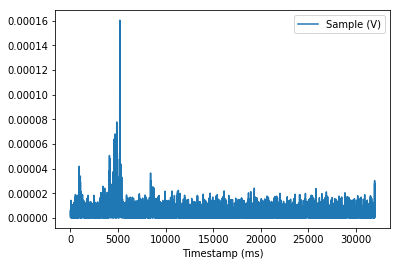

In [36]:
trial = 0
ZInds = np.diff(act_dict[task][trial][loc]['elec'].index)!=0
act_dict[task][trial][loc]['elec'] = act_dict[task][trial][loc]['elec'][np.hstack((ZInds,np.array(True)))]
filterdata(act_dict,task,loc,trial,'elec',ftype='bandpass',cutoff_bp=[20,70])
act_dict[task][trial][loc][sensor] = np.absolute(act_dict[task][trial][loc][sensor])
act_dict[task][trial][loc]['elec'].plot()
subj_score = mot_scores.loc[mot_scores['subject']==subj,['subject','visit','standing tremor left upper limb']]
print('Tremor score: ' + str(subj_score.iloc[trial]['standing tremor left upper limb']))

Tremor score: 0.0


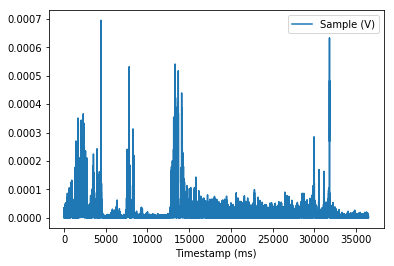

In [37]:
trial = 5
ZInds = np.diff(act_dict[task][trial][loc]['elec'].index)!=0
act_dict[task][trial][loc]['elec'] = act_dict[task][trial][loc]['elec'][np.hstack((ZInds,np.array(True)))]
filterdata(act_dict,task,loc,trial,'elec',ftype='bandpass',cutoff_bp=[20,70])
act_dict[task][trial][loc][sensor] = np.absolute(act_dict[task][trial][loc][sensor])
act_dict[task][trial][loc]['elec'].plot()
subj_score = mot_scores.loc[mot_scores['subject']==subj,['subject','visit','standing tremor left upper limb']]
print('Tremor score: ' + str(subj_score.iloc[trial]['standing tremor left upper limb']))

Tremor score: 3.0


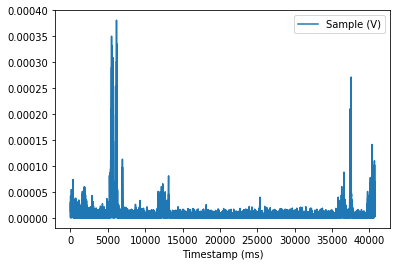

In [38]:
trial = 1
ZInds = np.diff(act_dict[task][trial][loc]['elec'].index)!=0
act_dict[task][trial][loc]['elec'] = act_dict[task][trial][loc]['elec'][np.hstack((ZInds,np.array(True)))]
filterdata(act_dict,task,loc,trial,'elec',ftype='bandpass',cutoff_bp=[20,70])
act_dict[task][trial][loc][sensor] = np.absolute(act_dict[task][trial][loc][sensor])
act_dict[task][trial][loc]['elec'].plot()
subj_score = mot_scores.loc[mot_scores['subject']==subj,['subject','visit','standing tremor left upper limb']]
print('Tremor score: ' + str(subj_score.iloc[trial]['standing tremor left upper limb']))

In [10]:
clip_data.keys()

NameError: name 'clip_data' is not defined

In [18]:
np.max(clip)[0]

0.0016709391927977324

In [22]:
np.mean(clip)[0]

0.0014903640722399743

In [76]:
d = {}
d.keys()

dict_keys([])

In [7]:
np.mean(clip[0])

NameError: name 'clip' is not defined

In [15]:
features_list = ['RMS','mean','var','skew','kurt','binen','energy','MAV']
feature_cols = []
for w in range(11):
    for i in range(len(features_list)):
        feature_cols = feature_cols + [features_list[i] + str(w)]
        
len(feature_cols)

88

In [16]:
np.full(88,np.nan)

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])